In [1]:
import os
import base64
import imageio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.agents import CategoricalDqnAgent
from tf_agents.networks import q_network
from tf_agents.networks import categorical_q_network
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import policy_saver
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

NOTES = 100
MAX_SP_GAUGE = 6000
MAX_SP_VOLTAGE = 250000

In [2]:
import logging
from datetime import datetime
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
LOG_FILENAME = datetime.now().strftime('_%H_%M_%S_%d_%m_%Y.log')
logging.basicConfig(filename=LOG_FILENAME,level=logging.DEBUG)    

In [3]:
class SongEnv(py_environment.PyEnvironment):

  def __init__(self):
    self.TEAM = pd.DataFrame([{'pos': 1, 'name':"Char_1", 'strategy':0, 'appeal':10000},
                            {'pos': 2, 'name':"Char_2", 'strategy':1, 'appeal':8000},
                            {'pos': 3, 'name':"Char_3", 'strategy':2, 'appeal':5000}])
    self.NOTES = 100
    self.MAX_SP_GAUGE = 6000
    self.MAX_SP_VOLTAGE = 250000
    self.sp_skill = sum(self.TEAM['appeal'])
    if self.sp_skill > self.MAX_SP_VOLTAGE:
        self.sp_skill = self.MAAX_SP_VOLTAGE
    #I'm starting with 6 actions - hit, miss, 3 swaps, and SP Skill.
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=5, name='action')
    #Currently 19 observations are set as follows:
    #1: current note
    #2: max notes
    #3: score max score set to 1 billion.
    #4: Current strategy. 0, 1, or 2 (red, geren, blue)
    #5-7: Can you swap to each strategy? (0 or 1 depending on current strategy)
    #8: Strat swap cooldown (From 0 to 5)
    #9: SP Gauge value
    #10: SP Gauge max
    #11: SP Skill Useable?
    #12: SP Skill Value
    #13-15: The appeal stats of the 3 characters.
    #16-18: The strategies of each of the 3 characters.
    #19: S-rank score
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,18), dtype=np.float32, minimum=[1,self.NOTES,0,0,0,0,0,0,0,3600,0,0,0,0,0,0,0,0],
                      maximum=[self.NOTES+1,self.NOTES,1e+9,2,1,1,1,5,self.MAX_SP_GAUGE,7200,1,self.MAX_SP_VOLTAGE,1e+6,1e+6,1e+6,2,2,2], name='observation')   
    self._episode_ended = False
    self.improper_use_counter = 0
    self.max_mistakes = 10
    
    self.reward = 0
    
    #Can swap red and blue, but not green at start.
    #Row 1 goes up to observation #12
    
    self._state = [1,self.NOTES,0,1,1,0,1,0,0,self.MAX_SP_GAUGE,0,self.sp_skill,
                   self.TEAM['appeal'].iloc[0],self.TEAM['appeal'].iloc[1],self.TEAM['appeal'].iloc[2],self.TEAM['strategy'].iloc[0],self.TEAM['strategy'].iloc[1],self.TEAM['strategy'].iloc[2]]
    
  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._episode_ended = False
    self._state = [1,self.NOTES,0,1,1,0,1,0,0,self.MAX_SP_GAUGE,0,self.sp_skill,
                   self.TEAM['appeal'].iloc[0],self.TEAM['appeal'].iloc[1],self.TEAM['appeal'].iloc[2],self.TEAM['strategy'].iloc[0],self.TEAM['strategy'].iloc[1],self.TEAM['strategy'].iloc[2]]
    self.improper_use_counter = 0
    self.reward = 0
    return ts.restart(np.array([self._state], dtype=np.float32))

  def decrement_swap(self):
    if self._state[7] > 0:
        self._state[7] -= 1
    return(self)

  def reset_swap(self):
    self._state[7] = 5
    return(self)

  def get_possible_appeals(self,appeal):
    self.reward += appeal - max(self.TEAM['appeal']) #Gives a reward based on how far the appealed value was from the maximum possible.
    
    return(self)

  def hit_note(self):
    if self._state[0] <= self._state[1]: #If there are still notes to hit 
        if self._state[3] == self._state[15]: #If the current strategy is red
            self._state[2] += self._state[12] #Add the appeal of the red character to the score
            self.reward += self._state[12]
            #reward = self.get_possible_appeals(reward,self._state[12]) #And the reward is how much you appealed
        elif self._state[3] == self._state[16]:
            self._state[2] += self._state[13]
            self.reward += self._state[13]
            #reward = self.get_possible_appeals(reward,self._state[13])
        else:
            self._state[2] += self._state[14]
            self.reward += self._state[14]
            #reward = self.get_possible_appeals(reward,self._state[14])
    
        self._state[0] += 1 #Increase the note count by 1.
        self.update_sp_skill() #Add to the SP gauge

        self.decrement_swap() #Decrement the counter until the next swap if it's not 0 already.
    elif self.improper_use_counter <= self.max_mistakes:
        self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        self.improper_use_counter += 1
    else:
        self.reward += -20000
        self._episode_ended = True
    return(self)
    
  #This is mostly for training purposes as there's obviously no practical purpose for missing the note instead of hitting it.
  def miss_note(self):
    if self._state[0] <= self._state[1]: #If there are still notes to hit (or miss I guess) 
        self._state[0] += 1
        self.decrement_swap()
    elif self.improper_use_counter <= self.max_mistakes:
        self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        self.improper_use_counter += 1
    else:
        self.reward += -20000
        self._episode_ended = True
    return(self)

  def swap_red(self):
    #Check that you're not on red already and that the cooldown is 0.
    if self._state[4] == 1 and self._state[7] == 0: #If you can swap red and the swap is off cooldown
        self._state[3] = 0 #Switch current strategy to red
    
        #Change ability to swap to other strategies
        self._state[4] = 0 #Can no longer swap to red.
        self._state[5] = 1 #Can swap to green
        self._state[6] = 1 #Can swap to blue
        
        self.reset_swap() #Reset swap cooldown to 5
    elif self.improper_use_counter <= self.max_mistakes:
        self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        self.improper_use_counter += 1
    else:
        self.reward += -20000
        self._episode_ended = True
    return(self)

  def swap_green(self):
    if self._state[5] == 1 and self._state[7] == 0:
        self._state[3] = 1
    
        #Change ability to swap to other strategies
        self._state[4] = 1
        self._state[5] = 0
        self._state[6] = 1
        
        self.reset_swap()
    elif self.improper_use_counter <= self.max_mistakes:
        self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        self.improper_use_counter += 1
    else:
        self.reward += -20000
        self._episode_ended = True
    return(self)

  def swap_blue(self):
    if self._state[6] == 1 and self._state[7] == 0:
        self._state[3] = 2
    
        #Change ability to swap to other strategies
        self._state[4] = 1
        self._state[5] = 1
        self._state[6] = 0
        
        self.reset_swap()
    elif self.improper_use_counter <= self.max_mistakes:
        self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        self.improper_use_counter += 1
    else:
        self.reward += -20000
        self._episode_ended = True
    return(self)

 #Increases the reward the further the agent makes it into the song.
  def progress_bonus(self):
    self.reward *= (self._state[0]/self._state[1])
    return(self)

  def use_sp_skill(self):
    if self._state[10] == 1: #If the SP Skill is useable
        self._state[10] = 0 #Set it to no longer be useable
        self._state[8] = 0 #Set the SP gauge value to 0
        self._state[2] += self._state[11] #Add the SP voltage to the score
        self.reward += self._state[11] #Reward is the voltage
    elif self.improper_use_counter <= self.max_mistakes:
        self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        self.improper_use_counter += 1
    else:
        self.reward += -20000
        self._episode_ended = True
    return(self)

  def update_sp_skill(self):
    if self._state[8] < self._state[9]: #If the gauge isn't already full
        self._state[8] += 200 #Add SP to the SP gauge
    if self._state[8] >= self._state[9]: #If adding SP would've put it over the max
        self._state[8] = self._state[9] #Set the value to the max
        self._state[10] = 1 #And make the SP skill usable 
    return(self)      

  def sp_hold_punish(self,action):
    if self._state[10] == 1 and action!=5: #If the SP Skill is available and is not queued to be used
        self.reward -= 1000 #Punish the agent.
    return(self)

  def _step(self, action):
    #If The last action ended the episode ignore the current action and start a new episode.
    if self._episode_ended:
      return self.reset()
    
    #Ends after the last note, when neither a swap or SP skill are available.
    elif self._state[0] >= self._state[1] and self._state[7] == 0 and self._state[10] == 0:
      self._episode_ended = True
    
    elif action == 0:
        self = self.hit_note()
    elif action == 1:
        self = self.miss_note()
    elif action == 2:
        self = self.swap_red()
    elif action == 3:
        self = self.swap_green()
    elif action == 4:
        self = self.swap_blue()
    elif action == 5:
        self = self.use_sp_skill()
    else:
      raise ValueError('`action` should be an integer 0 through 5.')
    
    if self._episode_ended:
      #Reward for successfully clearing all notes and having no swaps or SP skill available at the end.
      if self._state[0] >= self._state[1] and self._state[7] > 0 and self._state[10] == 0:
          self.reward += self._state[2] + 5e+9 #Give it a fat reward for making it to the end. Tried to pick a number that will always make passing have a higher reward than failing with a high score.
      return ts.termination(np.array([self._state], dtype=np.float32), self.reward)
    else:
      return ts.transition(np.array([self._state], dtype=np.float32), reward=self.reward, discount=1.0)

In [4]:
class SongEnvLogger(SongEnv):
    def hit_note(self):
        appealed_for = 0
        if self._state[0] <= self._state[1]: #If there are still notes to hit 
            if self._state[3] == self._state[15]: #If the current strategy is red
                self._state[2] += self._state[12] #Add the appeal of the red character to the score
                self.reward += self._state[12] #And the reward is how much you appealed
                appealed_for = self._state[12] 
            elif self._state[3] == self._state[16]:
                self._state[2] += self._state[13]
                self.reward += self._state[13]
                appealed_for = self._state[13] 
            else:
                self._state[2] += self._state[14]
                self.reward += self._state[14]
                appealed_for = self._state[14] 
                
            self._state[0] += 1 #Increase the note count by 1.
            self.update_sp_skill() #Add to the SP gauge
            self.decrement_swap() #Decrement the counter until the next swap if it's not 0 already.
            
            logging.info([self.TEAM[self.TEAM['strategy']==self._state[3]]['name'].values[0]," appealed for ", appealed_for," points. Current score: ",self._state[2],". SP Gauge: ",self._state[8],"/",self._state[9],". Note:",self._state[0],"/",self._state[1]])
            
        elif self.improper_use_counter <= self.max_mistakes:
            self.improper_use_counter += 1
            logging.info(["Attempted to hit note after song already ended. Mistakes made: ",self.improper_use_counter])
            self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        else:
            logging.info("Attempted to hit note after song already ended. Terminating play")
            self.reward += -20000
            self._episode_ended = True
            
        return(self)
    
    def miss_note(self):
        if self._state[0] <= self._state[1]: #If there are still notes to hit (or miss I guess) )
            self._state[0] += 1
            self.decrement_swap()
            logging.info(["Missed note. Current score: ",self._state[2],". SP Gauge: ",self._state[8],"/",self._state[9],". Note:",self._state[0],"/",self._state[1]])
        elif self.improper_use_counter <= self.max_mistakes:
            self.improper_use_counter += 1
            logging.info(["Attempted to hit note after song already ended. Mistakes made: ",self.improper_use_counter])
            self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        else:
            logging.info("Attempted to hit note after song already ended. Terminating play")
            self.reward += -20000
            self._episode_ended = True
        return(self)
    
    def swap_red(self):
        #Check that you're not on red already and that the cooldown is 0.
        if self._state[4] == 1 and self._state[7] == 0: #If swapping to red is possible and the swap is off-cooldown
            self._state[3] = 0 #Set the current strategy to red

            #Change ability to swap to other strategies
            self._state[4] = 0 #Can't swap red
            self._state[5] = 1 #Can swap green
            self._state[6] = 1 #Can swap blue

            self.reset_swap() #Set cooldown to 5
            logging.info("Swapped red")
            
        elif self.improper_use_counter <= self.max_mistakes:
            self.improper_use_counter += 1
            logging.info(["Attempted to swap red when it was on cooldown. Mistakes made: ",self.improper_use_counter])
            self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        else:
            logging.info("Attempted to swap red when it was on cooldown. Terminating play")
            self.reward += -20000
            self._episode_ended = True
        return(self)
    
    def swap_green(self):
        if self._state[5] == 1 and self._state[7] == 0:
            self._state[3] = 1

            #Change ability to swap to other strategies
            self._state[4] = 1
            self._state[5] = 0
            self._state[6] = 1

            self.reset_swap()
            logging.info("Swapped green")
        elif self.improper_use_counter <= self.max_mistakes:
            self.improper_use_counter += 1
            logging.info(["Attempted to swap green when it was on cooldown. Mistakes made: ",self.improper_use_counter])
            self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        else:
            logging.info("Attempted to swap green when it was on cooldown. Terminating play")
            self.reward += -20000
            self._episode_ended = True
        return(self)

    def swap_blue(self):
        if self._state[6] == 1 and self._state[7] == 0:
            self._state[3] = 2

            #Change ability to swap to other strategies
            self._state[4] = 1
            self._state[5] = 1
            self._state[6] = 0

            self.reset_swap()
            logging.info("Swapped blue")
        elif self.improper_use_counter <= self.max_mistakes:
            self.improper_use_counter += 1
            logging.info(["Attempted to swap blue when it was on cooldown. Mistakes made: ",self.improper_use_counter])
            self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        else:
            logging.info("Attempted to swap blue when it was on cooldown. Terminating play")
            self.reward += -20000
            self._episode_ended = True
        return(self)

    def use_sp_skill(self):
        if self._state[10] == 1: #If the SP Skill is useable
            self._state[10] = 0 #Set it to not being useable
            self._state[8] = 0 #Set the SP gauge value to 0
            self._state[2] += self._state[11] #Add the SP voltage to the score
            self.reward = self._state[11] #Reward is the voltage
            logging.info(["Used SP skill for ", self._state[11], "voltage. Current score: ",self._state[2],". SP Gauge: ",self._state[8],"/",self._state[9],". Note:",self._state[0],"/",self._state[1]])
        elif self.improper_use_counter <= self.max_mistakes:
            self.improper_use_counter += 1
            logging.info(["Attempted to use SP skill while on cooldown. Mistakes made: ",self.improper_use_counter])
            self.reward += -20000 #Punish it for trying to hit a note after the last one passed.
        else:
            logging.info("Attempted to use SP skill while on cooldown. Terminating play")
            self.reward += -20000
            self._episode_ended = True
        return(self)

In [5]:
train_env = SongEnv()
evaluation_py_env = SongEnv()

train_env = tf_py_environment.TFPyEnvironment(train_env)
evaluation_env = tf_py_environment.TFPyEnvironment(evaluation_py_env)

In [7]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 256  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 1  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [8]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(evaluation_env, random_policy, num_eval_episodes)

-1990000.0

In [10]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

In [11]:
logger_env = tf_py_environment.TFPyEnvironment(SongEnvLogger())
logger_env_py = SongEnvLogger()

In [12]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(evaluation_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience)

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(logger_env, agent.policy, num_eval_episodes)
        logging.info(["Step num: ",step,"Avg return: ",avg_return])
        print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 70.92072296142578
step = 400: loss = 49.652984619140625
step = 600: loss = 178.75965881347656
step = 800: loss = 34.42795181274414
step = 1000: loss = 15.994593620300293
step = 1000: Average Return = 800000.00
step = 1200: loss = 481.079345703125
step = 1400: loss = 59.13542556762695
step = 1600: loss = 249.08526611328125
step = 1800: loss = 44.43098449707031
step = 2000: loss = 15.917967796325684
step = 2000: Average Return = 4680000.00
step = 2200: loss = 259.4224853515625
step = 2400: loss = 173.61456298828125
step = 2600: loss = 32.656768798828125
step = 2800: loss = 59.935546875
step = 3000: loss = 14.871188163757324
step = 3000: Average Return = 48440000.00
step = 3200: loss = 248.63262939453125
step = 3400: loss = 3.32583594322204

step = 32400: loss = 0.1411244422197342
step = 32600: loss = 0.1874723881483078
step = 32800: loss = 0.14056751132011414
step = 33000: loss = 0.13380932807922363
step = 33000: Average Return = 19984000.00
step = 33200: loss = 0.21524861454963684
step = 33400: loss = 0.1759824901819229
step = 33600: loss = 0.2665477693080902
step = 33800: loss = 0.13912764191627502
step = 34000: loss = 0.18265564739704132
step = 34000: Average Return = 3396000.00
step = 34200: loss = 0.13583147525787354
step = 34400: loss = 0.1517665982246399
step = 34600: loss = 0.1939086765050888
step = 34800: loss = 0.18067599833011627
step = 35000: loss = 0.1977173388004303
step = 35000: Average Return = 22896000.00
step = 35200: loss = 0.144259974360466
step = 35400: loss = 0.2222655862569809
step = 35600: loss = 0.16149458289146423
step = 35800: loss = 0.1481257975101471
step = 36000: loss = 0.18491336703300476
step = 36000: Average Return = 18688000.00
step = 36200: loss = 0.12046626210212708
step = 36400: loss =

Text(0.5, 0, 'Step')

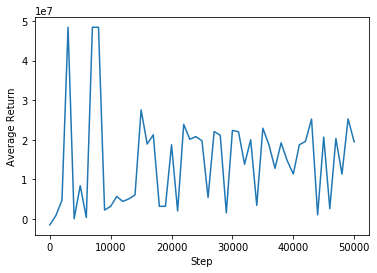

In [13]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')